In [1]:
%matplotlib inline


from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, classification_report
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt  


from collections import Counter
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier


# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:
df_train.shape, df_test.shape

((103679, 24), (44435, 24))

In [4]:

df_train = df_train.drop(columns=['averageRating', 'originalTitle'])
df_test = df_test.drop(columns=['averageRating', 'originalTitle'])

In [5]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)

In [6]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [7]:
from sklearn.utils.class_weight import compute_sample_weight

# This replicates class_weight='balanced'
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [9]:
param_list = {
    # 'n_estimators': [100, 200, 300],           # Number of trees in the forest
    # 'max_depth': list(np.arange(2, 15)),               # Limit tree depth to control overfitting
    'min_samples_split': [2, 5, 10, 20],               # Minimum samples to split an internal node
    'min_samples_leaf': [1, 5, 10, 20],                  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],           # Features considered at each split
    'criterion': ['gini', 'entropy'],

    }

clf = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', max_depth=12, random_state=42)
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_list,n_iter=64, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.3713514121750872
F1-score [0.26104059 0.47709022 0.28291762 0.47669971 0.2952381  0.1850864 ]
              precision    recall  f1-score   support

           0       0.18      0.47      0.26      1547
           1       0.45      0.50      0.48      9052
           2       0.45      0.21      0.28     11574
           3       0.54      0.42      0.48     14409
           4       0.30      0.29      0.30      6571
           5       0.11      0.62      0.19      1282

    accuracy                           0.37     44435
   macro avg       0.34      0.42      0.33     44435
weighted avg       0.44      0.37      0.38     44435



In [10]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'} 0.37321925227816033


In [11]:
y_train_pred = clf.predict(X_train)

In [12]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

Train Accuracy 0.494892890556429
Train F1-score [0.43809378 0.57113632 0.43573327 0.57390411 0.47721303 0.26936937]

Test Accuracy 0.3713514121750872
Test F1-score [0.26104059 0.47709022 0.28291762 0.47669971 0.2952381  0.1850864 ]


In [13]:
param_list = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500],           # Number of trees in the forest

            
             }

clf = RandomForestClassifier(**random_search.best_params_, max_depth=12, class_weight='balanced_subsample', random_state=42)
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_list, n_iter=8, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.3718015078204118
F1-score [0.26362165 0.47806053 0.28393099 0.476801   0.29405008 0.18471931]
              precision    recall  f1-score   support

           0       0.18      0.47      0.26      1547
           1       0.45      0.50      0.48      9052
           2       0.45      0.21      0.28     11574
           3       0.55      0.42      0.48     14409
           4       0.30      0.29      0.29      6571
           5       0.11      0.62      0.18      1282

    accuracy                           0.37     44435
   macro avg       0.34      0.42      0.33     44435
weighted avg       0.44      0.37      0.38     44435



In [14]:
results = pd.DataFrame(random_search.cv_results_)

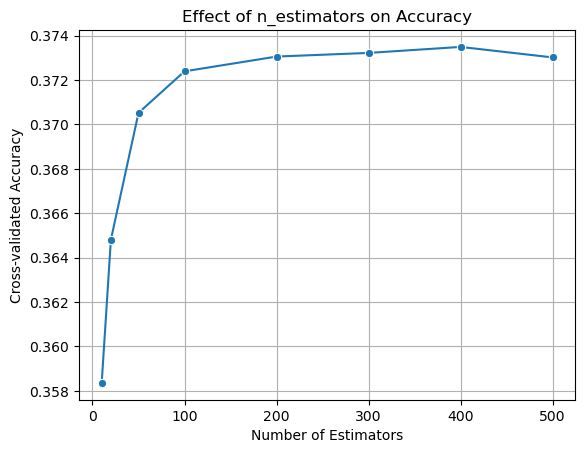

In [15]:
# Plot n_estimators vs. accuracy
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-validated Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.grid(True)
plt.show()

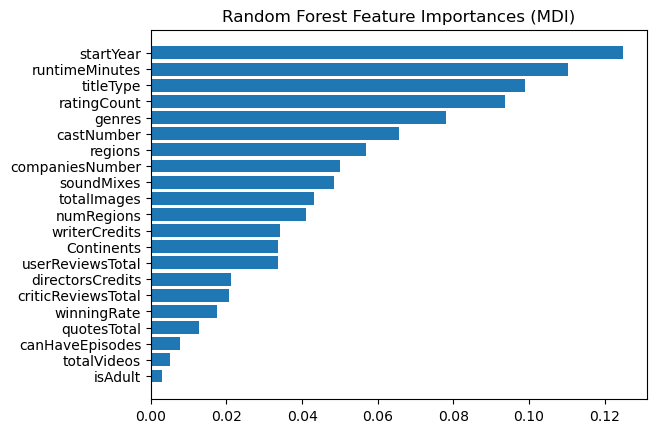

In [16]:
nbr_features = len(X_train.columns)

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(X_train.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [17]:
from sklearn.inspection import permutation_importance

In [18]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

C:\Users\hiend\AppData\Local\Temp\ipykernel_23916\3849782894.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(X_test.columns)[sorted_idx])


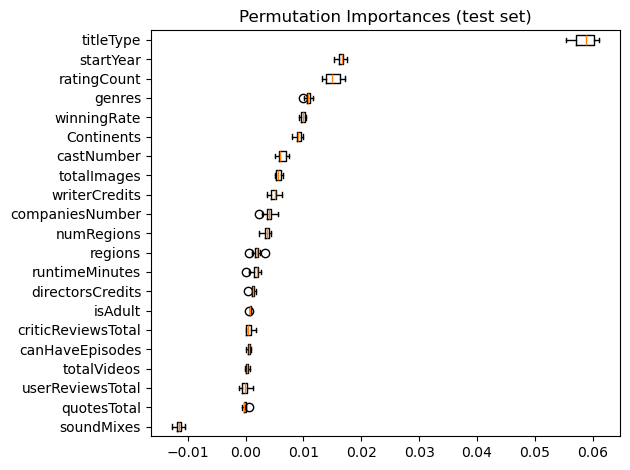

In [19]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

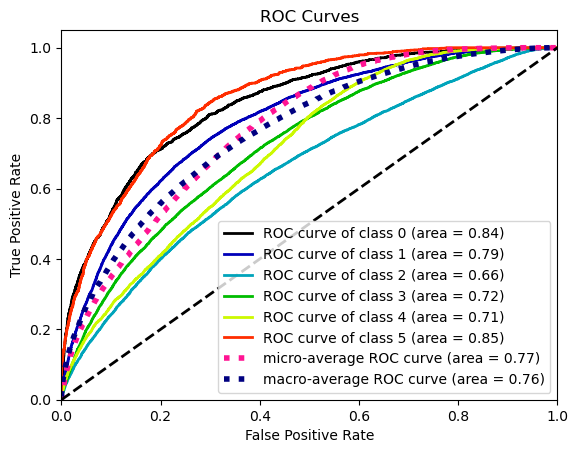

In [20]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

In [21]:
nodes = []
train_err = []
test_err = []

for max_depth in range(1, 20):
    rf = RandomForestClassifier(max_depth=max_depth, random_state=42, n_estimators=300)
    rf.fit(X_train, y_train)
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_err.append(1 - accuracy_score(y_train, y_train_pred))
    test_err.append(1 - accuracy_score(y_test, y_test_pred))

    avg_nodes = np.mean([estimator.tree_.node_count for estimator in rf.estimators_])
    nodes.append(avg_nodes)


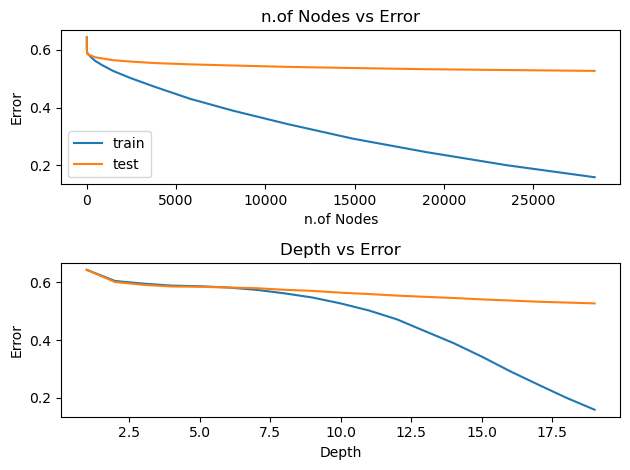

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(nodes, train_err, label='train')
ax[0].plot(nodes, test_err, label='test')
ax[0].legend()

ax[0].set_xlabel("n.of Nodes")
ax[0].set_ylabel("Error")
ax[0].set_title("n.of Nodes vs Error")

ax[1].plot(list(np.arange(1, 20)), train_err, label='train')
ax[1].plot(list(np.arange(1, 20)), test_err, label='test')

ax[1].set_xlabel("Depth")
ax[1].set_ylabel("Error")
ax[1].set_title("Depth vs Error")

plt.tight_layout()
plt.show()

# Boosting

In [23]:
from sklearn.ensemble import AdaBoostClassifier

If None, then the base estimator is DecisionTreeClassifier(max_depth=1).

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.1, 0.05, 0.01],
  # Learning rate for the AdaBoost algorithm


}
 
clf = AdaBoostClassifier()
# Randomized search
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train, sample_weight=sample_weights)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 45 is smaller than n_iter=60. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ValueError: Invalid parameter 'max-depth' for estimator AdaBoostClassifier(). Valid parameters are: ['algorithm', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

In [ ]:
print(random_search.best_params_, random_search.best_score_)

{'n_estimators': 500, 'learning_rate': 0.5} 0.30160398190570603


In [ ]:
results = pd.DataFrame(random_search.cv_results_)

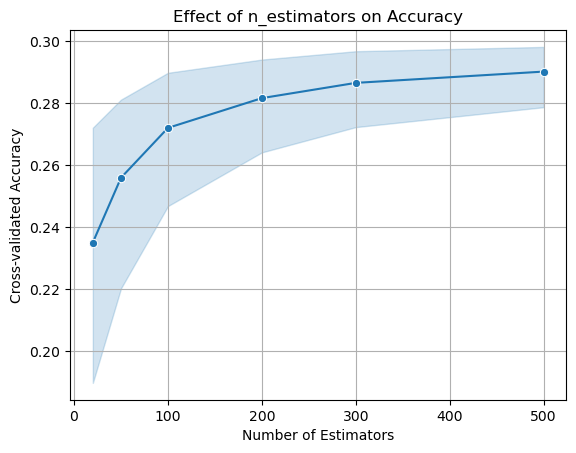

In [ ]:
# Plot n_estimators vs. accuracy
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', marker='o')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-validated Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.grid(True)
plt.show()

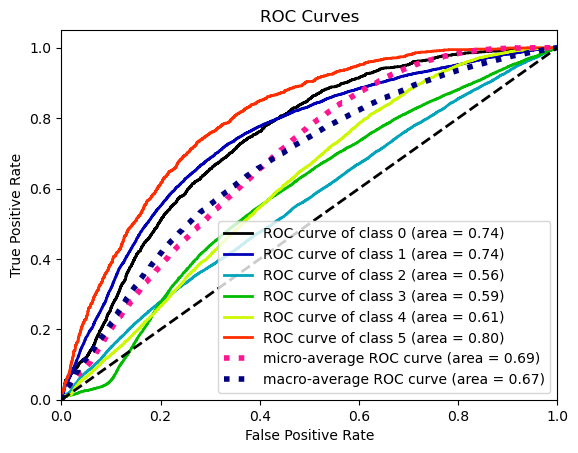

In [ ]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

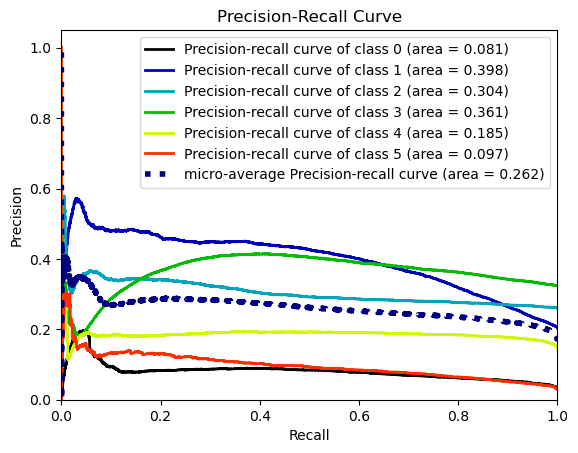

In [ ]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

In [ ]:

from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=300, learning_rate=0.5, random_state=0)
clf.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy 0.32170586249578037
F1-score [0.16531605 0.37823458 0.25595478 0.44345404 0.27849887 0.19284969]
              precision    recall  f1-score   support

           0       0.10      0.43      0.17      1547
           1       0.42      0.35      0.38      9052
           2       0.38      0.19      0.26     11574
           3       0.52      0.39      0.44     14409
           4       0.26      0.30      0.28      6571
           5       0.12      0.58      0.19      1282

    accuracy                           0.32     44435
   macro avg       0.30      0.37      0.29     44435
weighted avg       0.40      0.32      0.34     44435



In [ ]:
y_train_pred = clf.predict(X_train)

In [ ]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))

Train Accuracy 0.34030035011911763
Train F1-score [0.20819149 0.38856937 0.27197191 0.4530137  0.30493028 0.22698025]

Test Accuracy 0.32170586249578037
Test F1-score [0.16531605 0.37823458 0.25595478 0.44345404 0.27849887 0.19284969]
